In [35]:
from typing import List
from copy import deepcopy

import numpy as np
from scipy.linalg import norm, expm

import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
from qiskit.synthesis import LieTrotter
from qiskit.qasm2 import dumps

from quimb.tensor.tensor_1d import MatrixProductState
import quimb.tensor as qtn

## Single operator exponential.

In [12]:
ps1 = SparsePauliOp("XX")
ps2 = SparsePauliOp("YI")
ham = 0.5 * ps1 + 1.3 * ps2
nq = ham.num_qubits

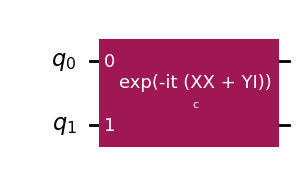

In [15]:
c = Parameter("c")
evo_gate = PauliEvolutionGate(ham, time=c, synthesis=LieTrotter(reps=1))
ckt = qiskit.QuantumCircuit(nq)
ckt.append(evo_gate, range(nq))

ckt.draw("mpl")

In [28]:
c.name

'c'

In [18]:
# Make a "concrete" version of the circuit that has a real parameter value.
concrete_c = 1.5
concrete_ckt = ckt.assign_parameters({"c": concrete_c})
concrete_ckt_qasm = dumps(concrete_ckt)

In [22]:
# Use quimb to apply this circuit to a state.
psi = np.random.rand(2 ** nq).astype(complex)
psi = psi / norm(psi)
psi_mps = MatrixProductState.from_dense(psi)

max_circuit_bond = 15
circuit_mps = qtn.circuit.CircuitMPS.from_openqasm2_str(
    concrete_ckt_qasm, psi0=psi_mps, max_bond=max_circuit_bond, progbar=False
)
evolved_mps = circuit_mps.psi


In [23]:
inner_prod = evolved_mps.H @ psi_mps
print(f"After evolution, got inner product {inner_prod}.")

After evolution, got inner product (-0.2708571937701937-0.10246178331998587j).


# A multi-layer "Ansatz"

In [59]:
psi = np.random.rand(2 ** nq).astype(complex)
psi = psi / norm(psi)
psi_mps = MatrixProductState.from_dense(psi)

In [64]:
def exponential_ansatz_state(
    ops: List[SparsePauliOp], coeffs: List[float], psi0: MatrixProductState,
    max_circuit_bond: int = 15
) -> MatrixProductState:
    """Given a set of operators {P_i} a set of coefficients c_i, and a state |psi0>, get the state
    e^{i c_1 P_1} e^{i c_2 P_2} ... e^{i c_3 P_3} |psi0>."""

    # In the real code, the pool class would compute these either on initialization or lazily.
    params = []
    ckts = []
    for i, op in enumerate(ops):
        c = Parameter(f"c{i}")
        evo_gate = PauliEvolutionGate(op, time=deepcopy(c), synthesis=LieTrotter(reps=1))
        ckt = qiskit.QuantumCircuit(nq)
        ckt.append(evo_gate, range(nq))
        ckts.append(ckt)
        params.append(deepcopy(c))
    
    # We don't want to build one big circuit up front because, in the real code,
    # we will dynamically add ops to the Ansatz.
    evolved_mps = psi0.copy()
    for coeff, param, ckt in zip(coeffs, params, ckts):
        concrete_ckt = ckt.assign_parameters({param.name: coeff})
        concrete_ckt_qasm = dumps(concrete_ckt)
        circuit_mps = qtn.circuit.CircuitMPS.from_openqasm2_str(
            concrete_ckt_qasm, psi0=evolved_mps, max_bond=max_circuit_bond, progbar=False
        )
        evolved_mps = circuit_mps.psi
    return evolved_mps

In [65]:
# Note this computes something different form the example above!
ops = [ps1, ps2]
coeffs = [1.0, 0.5]
ansatz_mps = exponential_ansatz_state(ops, coeffs, psi_mps)

In [70]:
# Compare this against exact exponentation.
ansatz_vec = psi.copy()
for op, coeff in zip(ops, coeffs):
    op_matrix = op.to_matrix()
    op_expm = expm(complex(0., -1.) * coeff * op_matrix)
    ansatz_vec = op_expm @ ansatz_vec
ansatz_vec_mps = MatrixProductState.from_dense(ansatz_vec)

In [71]:
print(abs(ansatz_vec_mps.H @ ansatz_mps))

0.7727344454325833
